# [Machine Learning with CoreML](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-core-ml)
**By:** Joshua Newnham (Author)  
**Publisher:** [Packt Publishing](https://www.packtpub.com/) 

## Chapter 7 - Fast Neural Style Transfer 
In the notebooks [NeuralStyleTransfer_Training_Content](https://github.com/PacktPublishing/Machine-Learning-with-Core-ML/blob/master/Chapter06/Notebooks/Training/NeuralStyleTransfer_Training_Content.ipynb) and [NeuralStyleTransfer_Training_Style](https://github.com/PacktPublishing/Machine-Learning-with-Core-ML/blob/master/Chapter06/Notebooks/Training/NeuralStyleTransfer_Training_Style.ipynb) we have seen how we can measure the loss for **content** and **style**. In this notebook we combine these two to complete *Neural Style Transfer*.  

At a highlevel; we first pass the image through the VGG network to calculate the total content and style loss. We then send this loss back through the network (aka backpropagation) to derive the gradient of the loss with respect to the input (generated) image. We then make a small update to the input (generated) image in the negative direction of the gradient which will cause our loss to decrease in value (gradient descent). We continue this process until we have satisfied an acceptable loss. 

<img src="images/content_and_style_loss.png" width="50%" />

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
from builtins import range, input 

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


In [4]:
import keras.backend as K
import numpy as np 
import matplotlib.pyplot as plt

In [5]:
from scipy.optimize import fmin_l_bfgs_b

In [6]:
from datetime import datetime

In [7]:
from PIL import Image # used to load images

--- 

In [8]:
TARGET_SIZE = (288,288)
STYLE_IMAGE = # PATH TO YOUR STYLE IMAGE 
CONTENT_IMAGE = # PATH TO YOUR CONTENT IMAGE 

--- 

In [9]:
### Re-create VGG16; replacing MaxPooling with AveragePooling 

In [10]:
def VGG16_AvgPool(shape):
    vgg16 = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    
    avg_vgg16 = Sequential() 
    for layer in vgg16.layers:
        if layer.__class__ == MaxPooling2D:
            avg_vgg16.add(AveragePooling2D())
        else:
            avg_vgg16.add(layer) 
            
    return avg_vgg16

In [11]:
def load_resize_image(img_path, target_size=TARGET_SIZE):
    """
    
    """
    # Load image 
    img = Image.open(img_path)
    
    # Get dimensions
    img_width, img_height = img.size

    # Crop
    target_width = min(img_width, img_height)
    target_height = min(img_width, img_height)

    left = (img_width - target_width)/2
    top = (img_height - target_height)/2
    right = (img_width + target_width)/2
    bottom = (img_height + target_height)/2

    img.crop((left, top, right, bottom))

    # Resize 
    img = img.resize(target_size)
    
    return img 

In [12]:
def preprocess(x):
    """
    https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py
    """

    rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    x = x - rn_mean

    return x[:, :, :, ::-1]

In [13]:
def unpreprocess(img):
    """
    Undo 'preprocess'
    """
    img = img[:, :, ::-1]
    img[...,0] += 103.939
    img[...,1] += 116.779
    img[...,2] += 123.68 #126.68
    img = np.clip(img, 0, 255).astype('uint8')
    
    return img 

In [14]:
def scale_img(img):
    img = img - img.min() 
    img = img / img.max() 
    return img 

In [15]:
def style_loss(y, t):
    """
    y: generated image 
    t: target image 
    """
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [16]:
def gram_matrix(img):
    """
    Input is (H, W, C) (C = # feature maps);
    we first need to convert it to HW, C    
    """
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
    
    # Now calculate the gram matrix 
    # gram = XX^T / N
    # The constant is not important since we'll be weighting these 
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements() 
    return G

In [17]:
def minimize(fn, epochs, batch_shape):
    t0 = datetime.now() 
    losses = [] 
    # initilise our generated image with random values 
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
            func=fn, 
            x0=x, 
            maxfun=20)
        x = np.clip(x, -127, 127)

        print("iteration {} loss {}".format(i, l))
        losses.append(l)
        
    t1 = datetime.now() 
    print("duration: {}".format(t1-t0))
    plt.plot(losses)
    plt.show() 
    
    output_img = x.reshape(*batch_shape)
    output_img = unpreprocess(output_img)
    return output_img[0] 

In [18]:
def transfer_style(style_path, content_path):
    style_img = load_resize_image(style_path)        
    
    # convert image to array and preprocess for vgg 
    style_img = image.img_to_array(style_img)
    style_img = np.asarray(style_img, dtype='float32')
    style_img = np.expand_dims(style_img, axis=0)
    #style_img = preprocess_input(style_img)
    style_img = preprocess(style_img)
    
    content_img = load_resize_image(content_path)        
    
    # convert image to array and preprocess for vgg 
    content_img = image.img_to_array(content_img)
    content_img = np.asarray(content_img, dtype='float32')
    content_img = np.expand_dims(content_img, axis=0)
    #content_img = preprocess_input(content_img)
    content_img = preprocess(content_img)    
    
    # grab the shape 
    batch_shape = style_img.shape 
    shape = style_img.shape[1:]    
    
    # make a single VGG model as our final model 
    # needs a common input     
    vgg = VGG16_AvgPool(shape)
    
    # create a content model; we only need 1 output 
    content_model = Model(vgg.input, vgg.layers[13].get_output_at(1))
    content_target = K.variable(content_model.predict(content_img))
    
    # Note: you need to select the output at index 1, since the 
    # output at index 0 corrosponds to the original vgg with maxpool 
    symbloic_conv_outputs = [
        layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')
    ]
    
    # create a big model that outputs multiple layers' outputs 
    style_model = Model(vgg.input, symbloic_conv_outputs)
    
    # calcualte the targets that are outputs for each layer 
    style_layer_outputs = [K.variable(y) for y in style_model.predict(style_img)]
    
    # we assume weight for content is 1 
    # and only weight style losses 
    style_weights = [0.2, 0.4, 0.6, 0.8, 1.0]
    
    # create a total loss which is the sum of content loss + style loss 
    loss = K.mean(K.square(content_model.output - content_target))
    
    for w, symbolic, actual in zip(style_weights, symbloic_conv_outputs, style_layer_outputs):
        # gram_matrix() expects a (H, W, C) as input 
        loss += w * style_loss(symbolic[0], actual[0])
    
    # once again, create the gradients and loss + grads function 
    # nb; it doesn't matter which model we get the input from, 
    # both point to the same location 
    grads = K.gradients(loss, vgg.input)    
    
    get_loss_and_grads = K.function(
        inputs=[vgg.input], 
        outputs=[loss] + grads)     
    
    def get_loss_and_grads_wrapper(x_vec):
        """
        scipy's minimizer allows us to pass back 
        function value f(x) and its gradient f'(x) 
        simultaneously rather than using the fprime arg 
        
        We cannot use get_loss_and_grads() directly, 
        the minimizer func must be a 1-D array. 
        Input to get_loss_and_grads must be [batch_of_images]
        
        Gradient must also be a 1-D array and both, 
        loss and graident, must be np.float64 otherwise we will 
        get an error
        """
        
        l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
        return l.astype(np.float64), g.flatten().astype(np.float64)
    
    output = minimize(get_loss_and_grads_wrapper, 10, batch_shape)        
    return output

iteration 0 loss 4201.046875
iteration 1 loss 727.7189331054688
iteration 2 loss 447.8688049316406
iteration 3 loss 347.0633850097656
iteration 4 loss 296.2172546386719
iteration 5 loss 267.68231201171875
iteration 6 loss 248.82778930664062
iteration 7 loss 235.63235473632812
iteration 8 loss 225.74806213378906
iteration 9 loss 217.82272338867188
duration: 0:07:00.518914


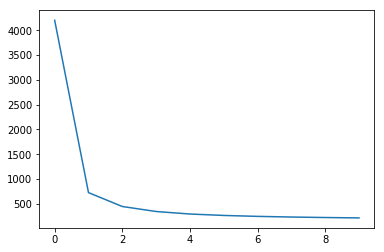

In [19]:
final_img = transfer_style(STYLE_IMAGE, CONTENT_IMAGE)

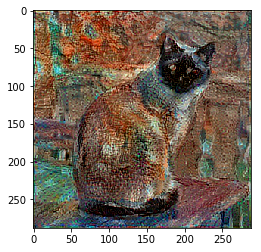

In [20]:
#plt.imshow(scale_img(final_img))
plt.imshow(final_img)
#plt.imshow(np.clip(final_img, 0, 255))
plt.show() 

--- 

In [25]:
img1 = load_resize_image(STYLE_IMAGE)        
    
# convert image to array and preprocess for vgg 
img1 = image.img_to_array(img1)
img1 = np.asarray(img1, dtype='float32')
img1 = np.expand_dims(img1, axis=0)
img1 = preprocess(img1)

In [26]:
img2 = load_resize_image(STYLE_IMAGE)        
    
# convert image to array and preprocess for vgg 
img2 = image.img_to_array(img2)
img2 = np.asarray(img2, dtype='float32')
img2 = np.expand_dims(img2, axis=0)
img2 = preprocess_input(img2)

In [27]:
img1.shape == img2.shape

True

In [28]:
img1.mean() == img2.mean()

True

In [29]:
img1.std() == img2.std()

True

In [30]:
img2.reshape(img2.shape[1:]).shape

(288, 288, 3)

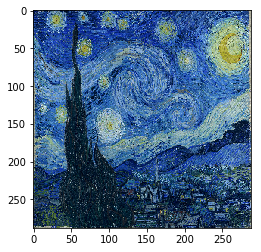

In [32]:
plt.imshow(scale_img(unpreprocess(img1.reshape(img1.shape[1:]))))

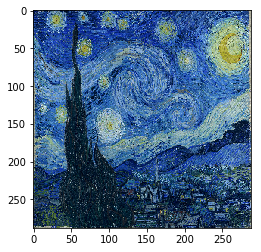

In [31]:
plt.imshow(scale_img(unpreprocess(img2.reshape(img2.shape[1:]))))